In [2]:
import pandas as pd 


In [3]:
df = pd.read_csv("2019-Oct.csv")

EDA

In [4]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 2.8+ GB


In [6]:
df.isnull().sum()


event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [7]:
df["event_type"].value_counts()


event_type
view        40779399
cart          926516
purchase      742849
Name: count, dtype: int64

In [8]:
df.describe()


,product_id,category_id,price,user_id
count,4.244876e+07,4.244876e+07,4.244876e+07,4.244876e+07
mean,1.054993e+07,2.057404e+18,2.903237e+02,5.335371e+08
std,1.188191e+07,1.843926e+16,3.582692e+02,1.852374e+07
min,1.000978e+06,2.053014e+18,0.000000e+00,3.386938e+07
25%,1.005157e+06,2.053014e+18,6.598000e+01,5.159043e+08
50%,5.000470e+06,2.053014e+18,1.629300e+02,5.296965e+08
75%,1.600030e+07,2.053014e+18,3.585700e+02,5.515788e+08
max,6.050001e+07,2.175420e+18,2.574070e+03,5.662809e+08


In [9]:
df = df.dropna(subset=["user_session"])


In [10]:
df.loc[:, "category_code"] = df["category_code"].fillna("unknown")
df.loc[:, "brand"] = df["brand"].fillna("unknown")

In [11]:
df.to_csv("ecommerce_cleaned.csv", index=False)


In [12]:
df_1 = pd.read_csv("ecommerce_cleaned.csv")

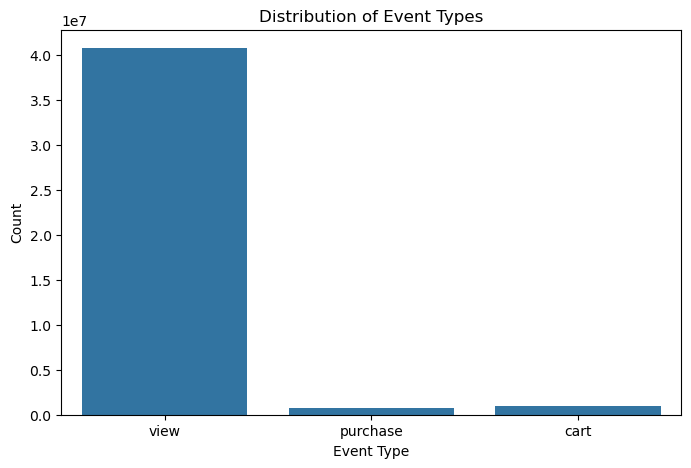

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=df_1["event_type"])
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


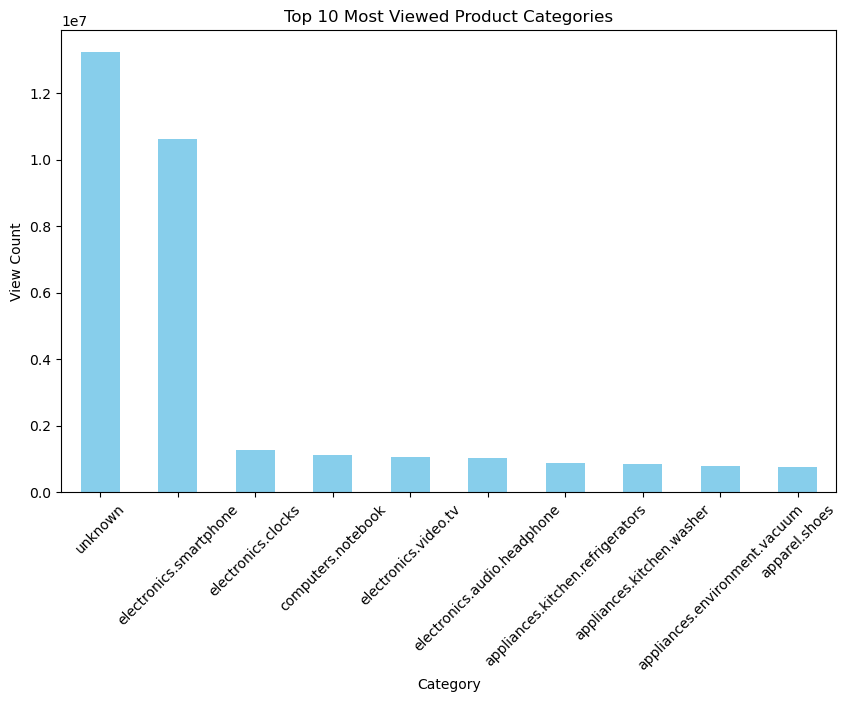

In [14]:
plt.figure(figsize=(10,6))
df_1[df_1["event_type"] == "view"]["category_code"].value_counts().head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Most Viewed Product Categories")
plt.xlabel("Category")
plt.ylabel("View Count")
plt.xticks(rotation=45)
plt.show()


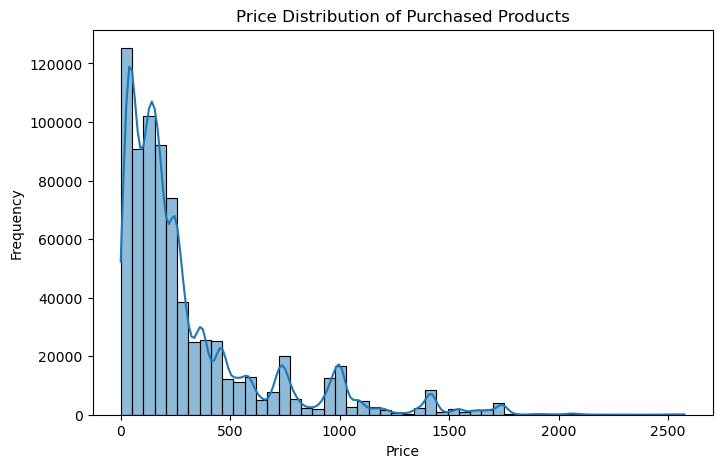

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df_1[df_1["event_type"] == "purchase"]["price"], bins=50, kde=True)
plt.title("Price Distribution of Purchased Products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


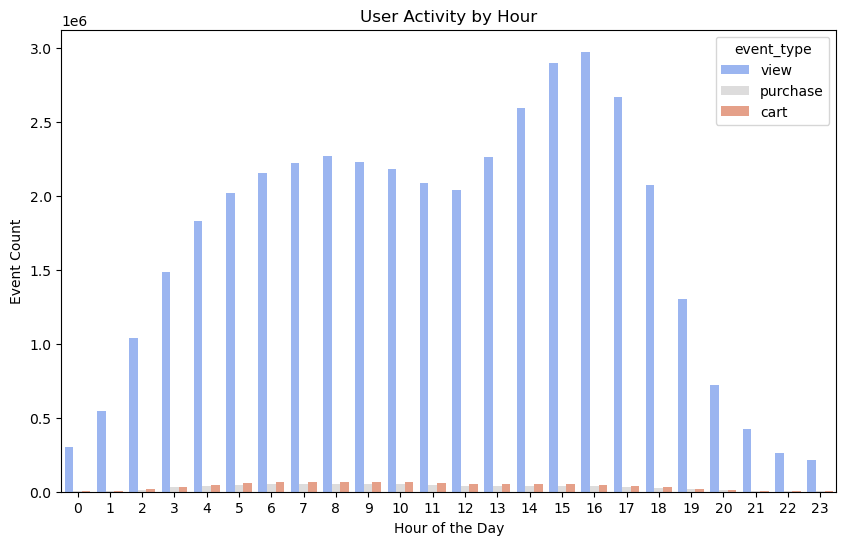

In [16]:
df = df_1.copy()  # Ensures it's an independent DataFrame
df["event_time"] = pd.to_datetime(df["event_time"])
df["hour"] = df["event_time"].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x=df["hour"], hue=df["event_type"], palette="coolwarm")
plt.title("User Activity by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Event Count")
plt.show()


In [17]:
cart_events = df_1[df_1["event_type"] == "cart"].shape[0]
purchase_events = df_1[df_1["event_type"] == "purchase"].shape[0]

conversion_rate = (purchase_events / cart_events) * 100
print(f"Conversion Rate: {conversion_rate:.2f}%")


Conversion Rate: 80.18%


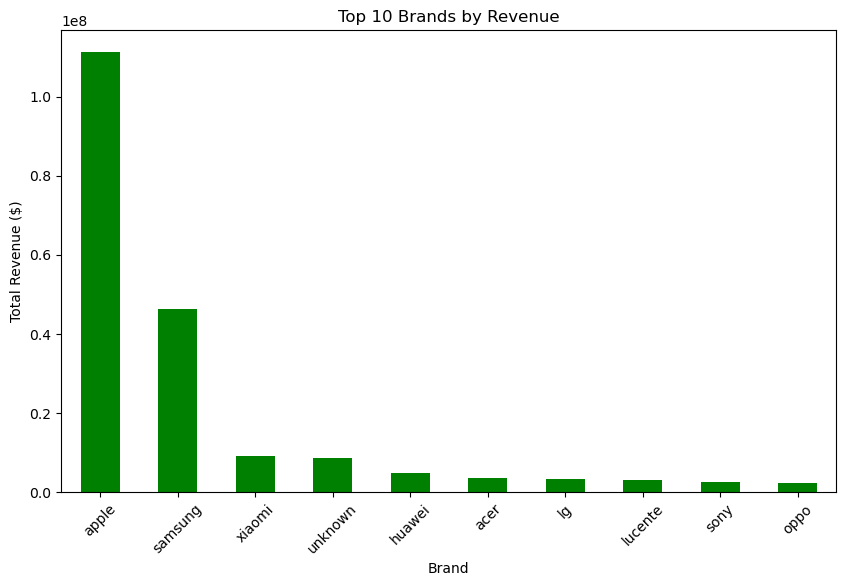

In [18]:
df_purchase = df_1[df_1["event_type"] == "purchase"]

# Group by brand and sum revenue
brand_revenue = df_purchase.groupby("brand")["price"].sum().sort_values(ascending=False).head(10)

# Plot revenue per brand
plt.figure(figsize=(10,6))
brand_revenue.plot(kind="bar", color="green")
plt.title("Top 10 Brands by Revenue")
plt.xlabel("Brand")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.show()


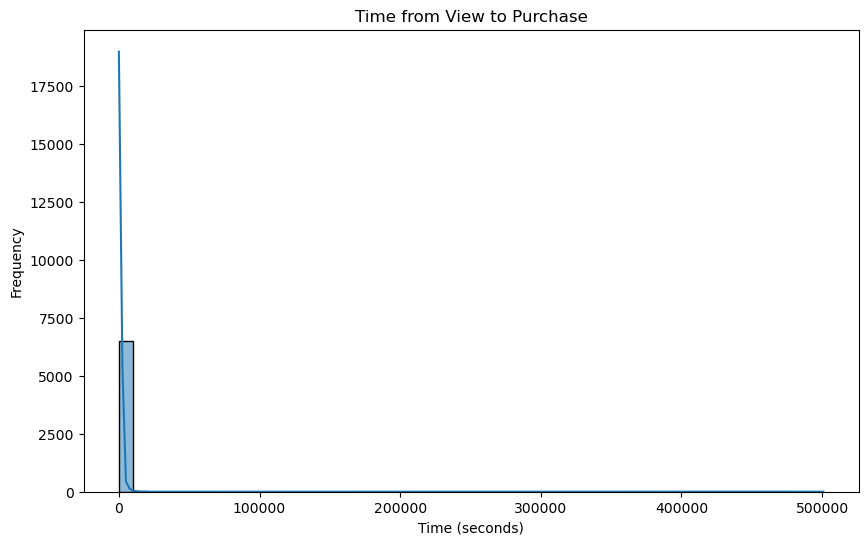

In [19]:
# Sample 5% to test logic without crashing memory
df_sample = df_1.sample(frac=0.05, random_state=42)

df_sample["event_time"] = pd.to_datetime(df_sample["event_time"])
df_sorted = df_sample.sort_values(["user_session", "event_time"])

# Keep only view and purchase rows
views = df_sorted[df_sorted["event_type"] == "view"]
purchases = df_sorted[df_sorted["event_type"] == "purchase"]

# Merge on session
merged = views.merge(purchases, on="user_session", suffixes=("_view", "_purchase"))

# Keep only where view happened before purchase
merged = merged[merged["event_time_view"] < merged["event_time_purchase"]]

# Get first matching pair per session
merged = merged.groupby("user_session").first().reset_index()

# Time difference in seconds
merged["time_diff"] = (merged["event_time_purchase"] - merged["event_time_view"]).dt.total_seconds()

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(merged["time_diff"], bins=50, kde=True)
plt.title("Time from View to Purchase")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.show()


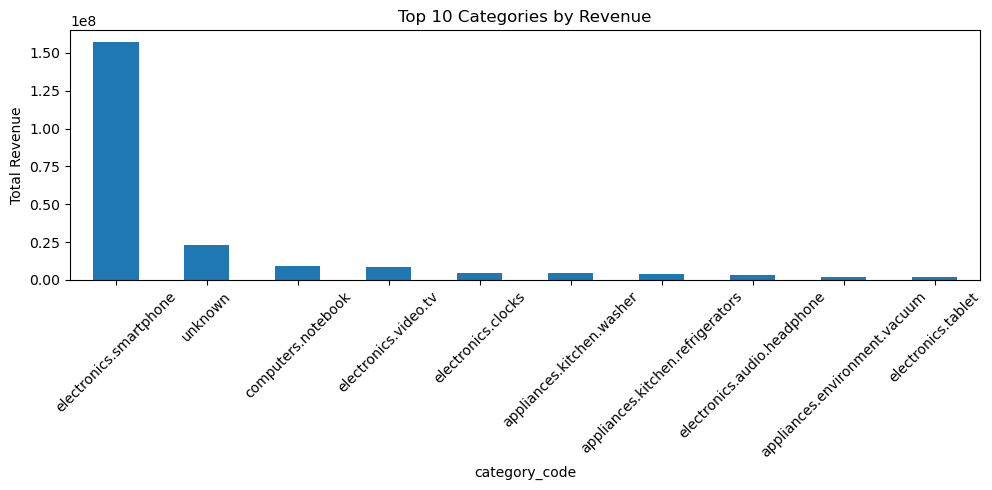

In [20]:
revenue_by_category = df[df["event_type"] == "purchase"].groupby("category_code")["price"].sum().sort_values(ascending=False).head(10)

revenue_by_category.plot(kind="bar", figsize=(10,5), title="Top 10 Categories by Revenue")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


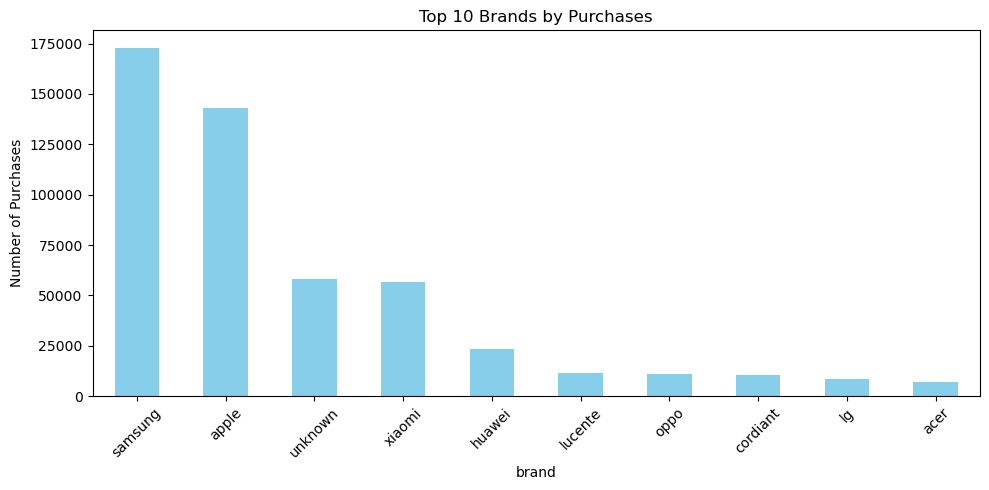

In [21]:
top_brands = df[df["event_type"] == "purchase"]["brand"].value_counts().head(10)

top_brands.plot(kind="bar", figsize=(10,5), title="Top 10 Brands by Purchases", color="skyblue")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


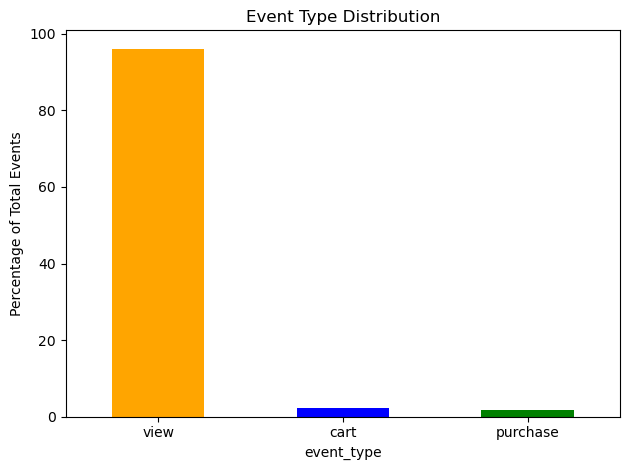

In [22]:
funnel = df["event_type"].value_counts(normalize=True) * 100

funnel.plot(kind="bar", title="Event Type Distribution", color=["orange", "blue", "green"])
plt.ylabel("Percentage of Total Events")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


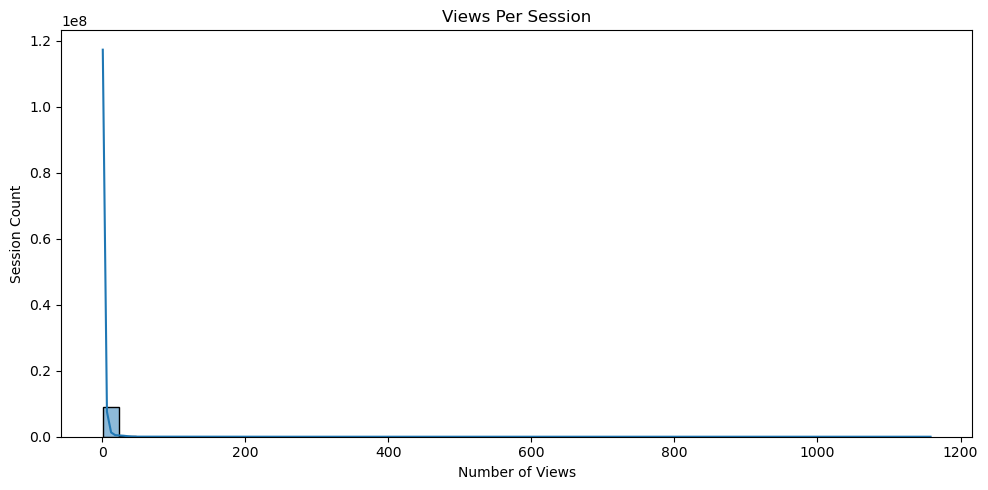

In [23]:
views_per_session = df[df["event_type"] == "view"].groupby("user_session").size()

plt.figure(figsize=(10,5))
sns.histplot(views_per_session, bins=50, kde=True)
plt.title("Views Per Session")
plt.xlabel("Number of Views")
plt.ylabel("Session Count")
plt.tight_layout()
plt.show()


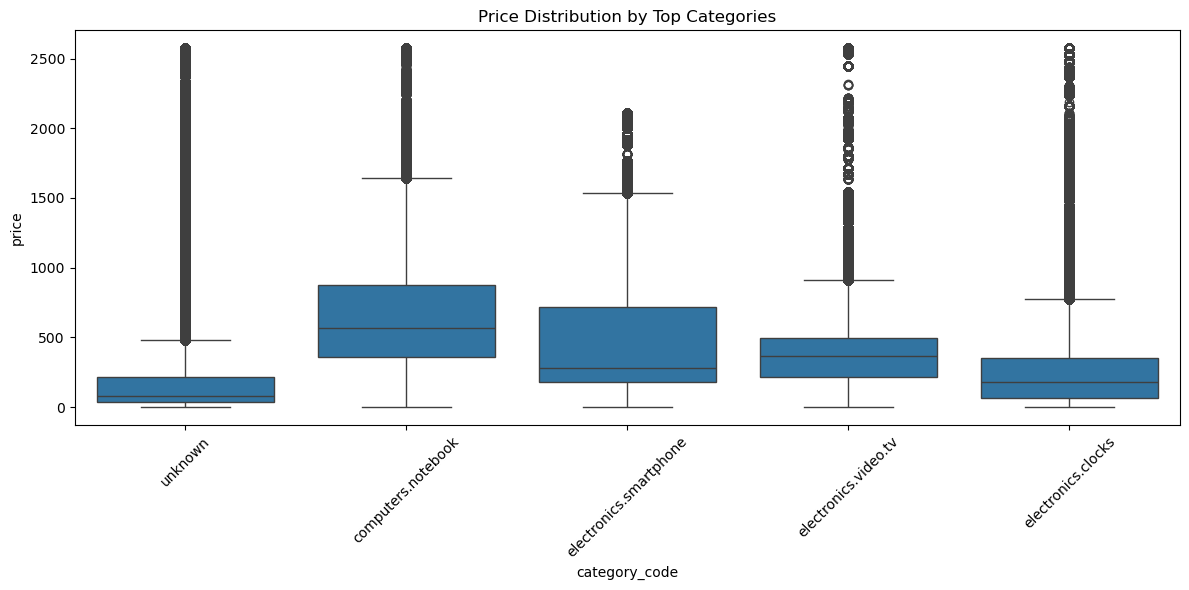

In [24]:
plt.figure(figsize=(12,6))
top_categories = df["category_code"].value_counts().head(5).index
sns.boxplot(data=df[df["category_code"].isin(top_categories)], x="category_code", y="price")
plt.title("Price Distribution by Top Categories")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")


In [26]:
df["hour"] = df["event_time"].dt.hour
df["day_of_week"] = df["event_time"].dt.dayofweek


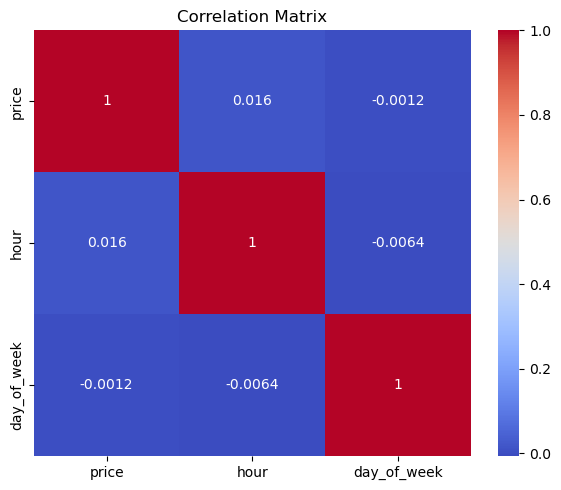

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[["price", "hour", "day_of_week"]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()
